# **Creating an Autoencoder**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, gzip, math, os, time, shutil
import fastcore.all as fc
from operator import attrgetter, itemgetter
from functools import partial
from collections.abc import Mapping
from pathlib import Path

import torch
from torch import nn, tensor, optim
from torch.utils.data import default_collate, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from miniai.training import * # Modules have already been developed in previous NBs
from miniai.datasets import * # and, reside in separate Github repo.
from miniai.conv import *
from fastprogress import progress_bar, master_bar

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=14, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging 
logging.disable(logging.WARNING)

## **Load Hugging Face Fashion MNIST Data**

Building on what we worked on in [NB 06_datasets](https://github.com/bachaudhry/FastAI-22-23/blob/main/course_part_2/06_datasets.ipynb), it is time to build models using the HuggingFace Fashion MNIST dataset.

In [3]:
name  = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description) # This provides handy meta data for the dataset.

In [4]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31049107.0, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5192560.0, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [5]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [6]:
# Preset image and label
x, y = 'image', 'label'
dsd = load_dataset(name)
dsd

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We need to convert each image into a tensor, so let's run the transformation using the `@inplace` decorator.

In [7]:
# Using our decorator from the same NB
@inplace
def transform_i(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [8]:
# Set Batch size and run transformation inplace
bs = 256
tds = dsd.with_transform(transform_i)

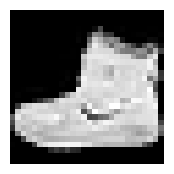

In [9]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(2,2));

In [10]:
# Collate func
# Take in a batch of data and put the elements within the batch into a tensor 
# with an additional outer dimension - batch size
cf = collate_dict(ds)

In [11]:
# Using the collate function with the to_device() function from nb-07
def collate_(b): return to_device(cf(b))
# Create the Dataloader function, which goes through each item in the dataset dict(dsd) and 
# creates a dict of dataloaders
# num workers added after slow CNN performance
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs,**kwargs) for k, v in dsd.items()}

In [12]:
dls = data_loaders(tds, bs, collate_fn=collate_)
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb95c2a2e90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb95ffd79d0>}

In [13]:
# Dataloaders for training and validation
dt = dls['train']
dv = dls['test']
# Grab x and y batches
xb, yb = next(iter(dt))

In [14]:
# Get names for the features
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [15]:
# Make a label getter and grab a minibatch of 16 imgs
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

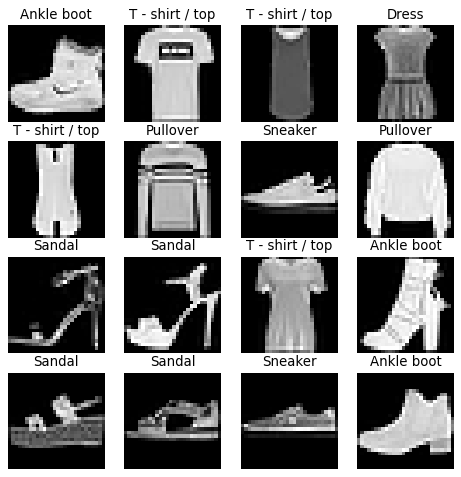

In [16]:
# View minibatch samples with labels
mpl.rcParams['figure.dpi'] = 80
show_images(xb[:16], imsize=1.8, titles=titles);

## **Create a Simple CNN Classifier**

In [17]:
bs = 256
lr = 0.4

In [18]:
# Setup NN using the conv() function from nb07 with 3x3 ks and stride-2
cnn = nn.Sequential(
    conv(1, 4),              #14x14
    conv(4, 8),              #7x7
    conv(8, 16),             #4x4
    conv(16, 16),            #2x2
    conv(16, 10, act=False), #1x1
    nn.Flatten()
).to(def_device)

In [19]:
opt = optim.SGD(cnn.parameters(), lr=lr)

%time loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 0.709018867301941 0.7452
1 0.5885242527008057 0.7884
2 0.4665113359212875 0.833
3 0.4400990271806717 0.8419
4 0.4214998272895813 0.848
CPU times: user 19.2 s, sys: 343 ms, total: 19.6 s
Wall time: 19.5 s


In [20]:
# Grabbing a single training sample
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

The sequential model is pretty slowly, especially when compared to the standard MNIST dataset used in NB-07. And the accuracy is pretty low, compared to the leaderboard on the [papers with code](https://paperswithcode.com/sota/image-classification-on-fashion-mnist) site.

Sticking to the issue of speed, the reason for the slower performance is due to fact the MNIST was loaded onto the GPU memory as a single, large tensor block. But the HuggingFace training set consists of separate PNG images, which aren't pre-converted into a single format. So the dataloader has to spend extra time decoding the images, which is very CPU intensive, so this effectively becomes a bottle-neck.

Adding the `num_workers`argument, set to a higher value, also throws an error due to the way the collate function works. So, in short we would have to rewrite the `fit()` function to handle these extra wrinkles.

## **AutoEncoder**

> (AutoEncoder) AE is one of the basic building blocks, which can be stacked to form hierarchical deep models to organize, compress, and extract high-level features without any labeled training data. It allows for unsupervised learning and non-linear feature extraction.

> ... an AE network can convert an input vector into a code vector using a set of recognition weights. Then, a set of generative weights are used to convert the code vector into an approximate reconstruction of the input vector.

> [AutoEncoders in Deep Learning - A Review with New Perspectives.](https://www.mdpi.com/2227-7390/11/8/1777)

In [21]:
def deconv(ni, nf, ks=3, act=True):
    # Padding=ks//2 uses a truncating division to handle odd numbers.
    layers  = [nn.UpsamplingNearest2d(scale_factor=2),
               nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU()) 
    return nn.Sequential(*layers)

In [22]:
# Moving eval() out of the primary fit function
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0., 0
        for xb, _ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item()*n
    print(epoch, f'{tot_loss / count:.3f}')

In [23]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            # Replacing yb with xb - since the autoencoder will be trained and evaluated
            # on samples from the training set.
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [44]:
# Autoencoder architecture
ae = nn.Sequential( #28x28 input
    nn.ZeroPad2d(2), #32x32 - Additional padding to ensure int division as we decrease the dim.
    conv(1, 2), #16x16
    conv(2, 4), #8x8
    #conv(4, 8), #4x4
    #deconv(8, 4), #8x8
    deconv(4, 2), #16x16
    deconv(2, 1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28 - Crop off the final two pixels after convs. are done.
    nn.Sigmoid()
).to(def_device)

In [45]:
# dv is the dataloader for validation
eval(ae, F.mse_loss, dv)

0 0.166


In [30]:
# Run SGD with the params of our autoencoder.
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.145
1 0.136
2 0.131
3 0.128
4 0.126


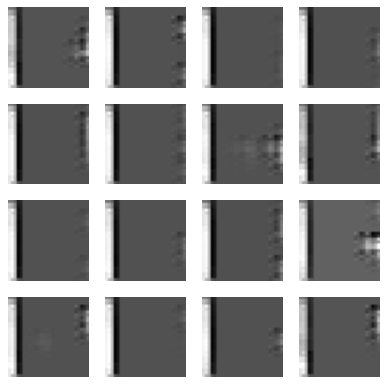

In [31]:
p = ae(xb) # Attempt 1
show_images(p[:16].data.cpu(), imsize=1.5)

In [46]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.107
1 0.042
2 0.035
3 0.031
4 0.029


Our objective is to have the autoencoder re-create the inputs as closely as possible. The AE, at present, clearly doesn't do the job well at all. Some improvements were seen after a `conv` and `deconv` layer were removed.

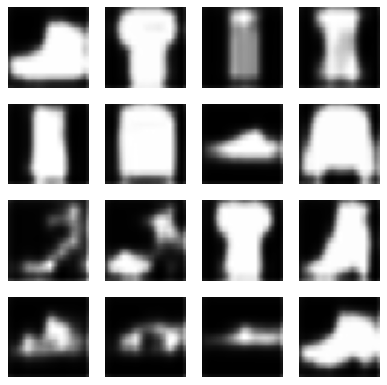

In [47]:
p = ae(xb) # Attempt 2
show_images(p[:16].data.cpu(), imsize=1.5)

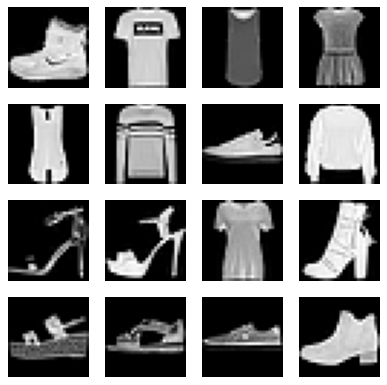

In [48]:
show_images(xb[:16].data.cpu(), imsize=1.5) # Training batch.

There are numerous ways which can improve the AE's results after sufficient experimentation. Which may include the usage of:
1. Variational AutoEncoders.
2. Improved Optimizers.
3. Improved Architectures etc etc.

Now, testing and implementing improvements can prove to be a cumbersome process. Our approach, uptill now, is simply **_not suited_** for rapid testing and deployment.